In [1]:
# CartPole-v1 using Q-learning

import gym
import cartpole
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Linear regression
from sklearn.linear_model import LinearRegression

from collections import deque

import random

from tensorflow import keras

from tqdm import tqdm

import multiprocessing

import time

sns.set_style("darkgrid")

In [36]:
class solver:
    def __init__(self, state_space, action_space, max_memory=10000, epsilon_exploration = 0.5, exploration_decay = 0.95,gamma = 0.99, learning_rate = 0.001):
        self.state_space = state_space
        self.action_space = action_space
        self.epsilon_exploration = epsilon_exploration
        self.exploration_decay = exploration_decay
        self.gamma = gamma
        self.learning_rate = learning_rate
        #self.discount = discount

        #Define the memory
        self.memory = deque()
        self.max_memory = max_memory

        #Define the model to approximate the Q function
        self.model = keras.Sequential()
        self.model.add(keras.layers.Dense(32, input_dim=state_space, activation='relu'))
        #self.model.add(keras.layers.Dropout(0.3))
        self.model.add(keras.layers.Dense(32, activation='relu')) #Hidden layer
        self.model.add(keras.layers.Dense(action_space, activation='linear')) #expected reward for each action
        #self.model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01)) #Apparently not a good idea in RL
        self.model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.001, rho = 0.95, epsilon = 0.01), loss='mse')

    def new_experience(self, state, action, reward, next_state, done):
        self.memory.append([state, action, reward, next_state, done])

    def act(self, state):
        #Explore
        if np.random.rand() <= self.epsilon_exploration:
            return np.random.randint(self.action_space) #Assuming start value is 0
        #Else exploit
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size=20):
        #Get a batch of experiences
        if len(self.memory) < batch_size:
            return
        else:
            batch = random.choices(self.memory, k=batch_size) #state, action, reward, next_state, done
            for state, action, reward, next_state, done in batch:
                if not done:
                    target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0))
                else:
                    target = reward
                target_f = self.model.predict(state, verbose=0)
                target_f[0][action] = target_f[0][action] + target
                self.model.fit(state, target_f, epochs=1, verbose=0, batch_size=1)

            self.epsilon_exploration *= self.exploration_decay
            self.epsilon_exploration = max(0.05, self.epsilon_exploration)

In [37]:
#Training the model

nb_episodes = 5
state_dim = 4
action_dim = 3 # 3 actions : left, right, do nothing

env_DQN = cartpole.CartPoleEnv(action_dim)
agent = solver(state_dim, action_dim)
timesteps = 1
scores_DQN = list()
steps_history_DQN = list()
for episode in tqdm(range(nb_episodes)):
    state = env_DQN.reset()
    state = np.reshape(state, [1, state_dim])
    done = False
    score = 0
    steps  = 0
    temps = time.time()
    while not done:
        steps += 1
        action = agent.act(state)
        next_state, reward, done, _ = env_DQN.step(action)
        next_state = np.reshape(next_state, [1, state_dim])
        if not done:
            reward = reward
        else:
            reward = -reward
        agent.new_experience(state, action, reward, next_state, done)
        state = next_state
        score += reward
        agent.replay() #Learn from the experience
    
    print(time.time() - temps)

    if episode % timesteps == 0:
        #print(steps)
        scores_DQN.append(score)
        steps_history_DQN.append(steps)
        

#Save the model

agent.model.save('model_DQN_replay_permament.h5')

 20%|██        | 1/5 [00:00<00:00,  4.42it/s]

0.22606468200683594


2023-03-20 00:22:10.925946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
 40%|████      | 2/5 [00:25<00:44, 14.99s/it]

25.325706005096436


 60%|██████    | 3/5 [01:40<01:24, 42.34s/it]

74.89037728309631


 80%|████████  | 4/5 [02:28<00:44, 44.42s/it]

47.592873096466064


100%|██████████| 5/5 [03:13<00:00, 38.71s/it]

45.49548816680908


1.68 µs ± 42.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


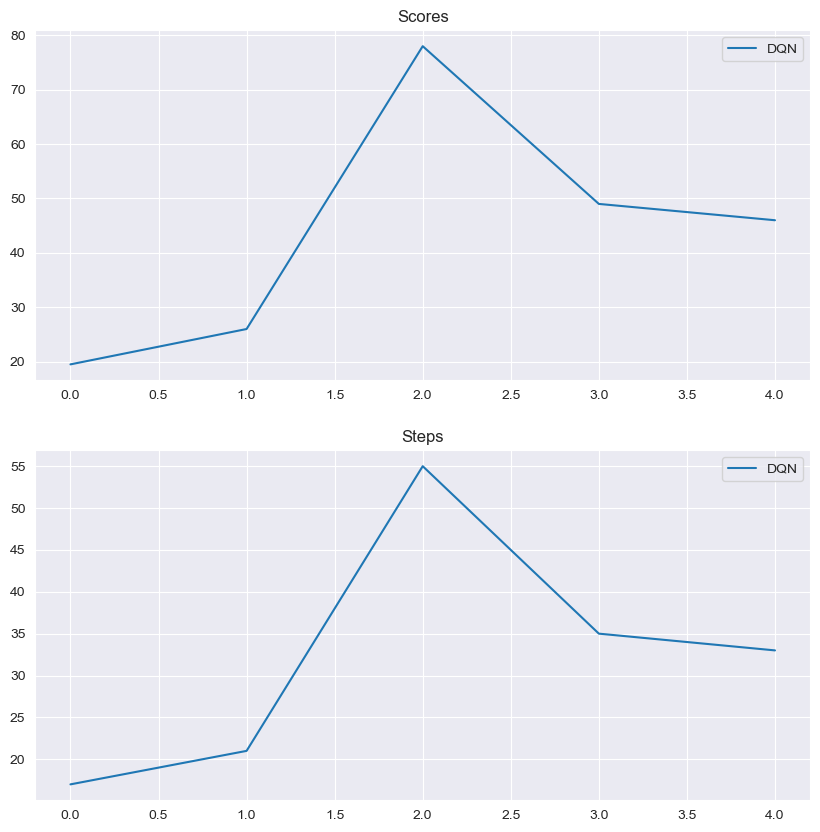

In [38]:


fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(scores_DQN, label='DQN')
axs[0].set_title('Scores')
axs[0].legend()
axs[1].plot(steps_history_DQN, label='DQN')
axs[1].set_title('Steps')
axs[1].legend()

plt.show()